In [7]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import os
import pickle
import torch.nn as nn
import torch.optim as optim

In [9]:
class BeamDataset(Dataset):
    def __init__(self, folder):
        self.data = self.load_dataset(folder)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        ## items from shape (2,54)-->(1,108) and (2,26)-->(1,52)
        input_data = self.data[index][0].reshape((1,108))
        label_data = self.data[index][1]
        label_index = self.data[index][2]
        
        return input_data, label_data, label_index
        
    def load_dataset(self,folder):
        filename = os.path.join(folder, "dataset_one_element.pkl")
        
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        return data

def visualize_samples(dataset, indices, title=None, count=5):
    plt.figure(figsize=(count*3,15))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        input_data,label_data,_ = dataset[index]
        plt.subplot(count,1,i+1)
        plt.title("Trajectory №%s [x/y] with error in " % index + label_data)
#         plt.plot(input_data[0],label='x')
#         plt.plot(input_data[1],label='y')
        plt.plot(input_data[0,:54],label='x')
        plt.plot(input_data[0,54:],label='y')
        plt.legend()
        plt.grid(False)
        plt.axis('on')  
        plt.subplots_adjust(hspace=0.5)
    

In [10]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

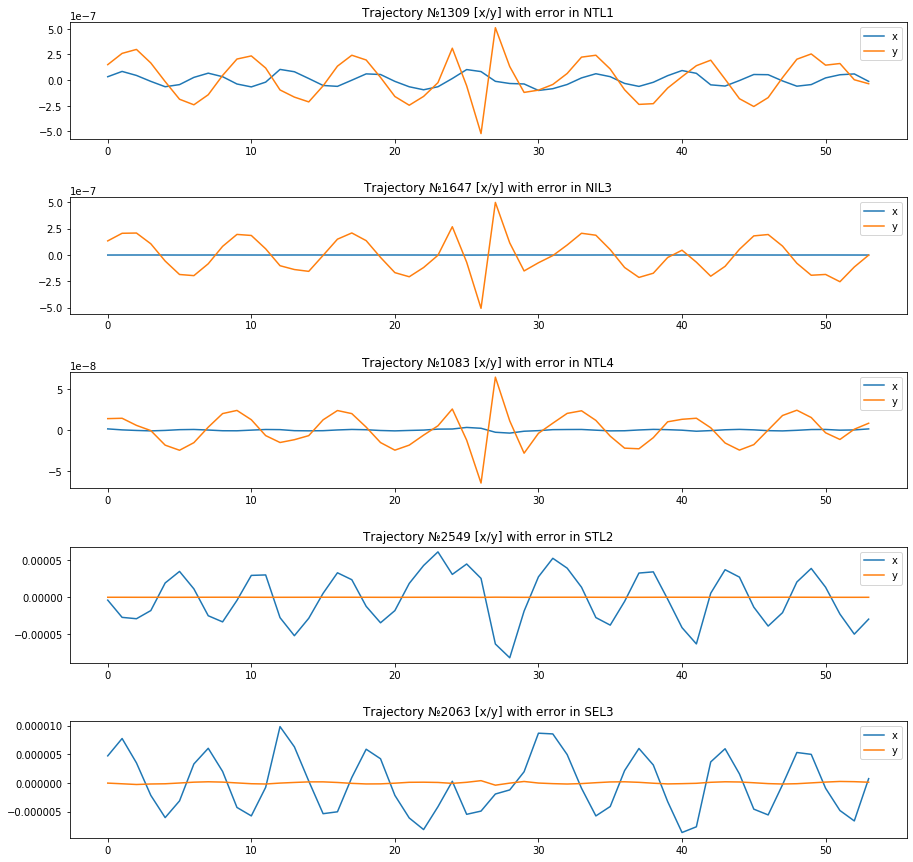

In [11]:
dataset = BeamDataset("")
indices = np.random.choice(np.arange(len(dataset)), 5, replace=False)
visualize_samples(dataset,indices)

In [12]:
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

train_dataset = dataset


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [16]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    orbits = []
    ave_loss = 0
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, _,y) in enumerate(train_loader):
             
#             x_gpu = x.to(device)
#             y_gpu = y.to(device)
            x_gpu = x
            y_gpu = y
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
           
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
              
            _,indices = torch.max(prediction,1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss_value

        if scheduler != None:
            scheduler.step()

        ave_loss = loss_accum/i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
#         print("Average Loss:", ave_loss.detach().numpy())
    orbits.append((prediction,y_gpu))  
    return loss_history, train_history, val_history, orbits
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    
    for i_step, (x, _,y) in enumerate(loader):
#         x_gpu = x.to(device)
#         y_gpu = y.to(device)
        x_gpu = x
        y_gpu = y

        prediction = model(x_gpu)    
            
        _,indices = torch.max(prediction,1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
        
    accuracy = float(correct_samples) / total_samples
    return accuracy

In [17]:
nn_model = nn.Sequential(
            nn.Conv1d(1, 2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm1d(1),
    
            nn.Conv1d(1, 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm1d(1),
 
            nn.Linear(27, 100,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),
    
            nn.Linear(100,200,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),

            Flattener(),
            nn.Linear(200,26,bias=True),
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
loss = nn.CrossEntropyLoss().type(torch.DoubleTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

Average loss: 3.301009, Train accuracy: 0.032083, Val accuracy: 0.028333
Average loss: 3.277624, Train accuracy: 0.040417, Val accuracy: 0.045000
Average loss: 3.275603, Train accuracy: 0.043333, Val accuracy: 0.036667
Average loss: 3.273533, Train accuracy: 0.043333, Val accuracy: 0.036667
Average loss: 3.272164, Train accuracy: 0.039167, Val accuracy: 0.058333
Average loss: 3.272658, Train accuracy: 0.032500, Val accuracy: 0.058333
Average loss: 3.269341, Train accuracy: 0.044167, Val accuracy: 0.058333
Average loss: 3.270673, Train accuracy: 0.038750, Val accuracy: 0.058333
Average loss: 3.269379, Train accuracy: 0.040000, Val accuracy: 0.058333
Average loss: 3.268417, Train accuracy: 0.044583, Val accuracy: 0.036667
Average loss: 3.267701, Train accuracy: 0.039167, Val accuracy: 0.040000
Average loss: 3.267677, Train accuracy: 0.044583, Val accuracy: 0.058333
Average loss: 3.266339, Train accuracy: 0.042917, Val accuracy: 0.058333
Average loss: 3.266033, Train accuracy: 0.047500, V

Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, Val accuracy: 0.058333
Average loss: 3.261908, Train accuracy: 0.047083, V